# Intent CPT Analysis Notebook

This notebook loads exported CPTs and validation predictions to compute:
- Mutual Information (from CPTs; assumes uniform prior over parent configurations)
- Marginal Effects per feature state (average expected lift in P(intent=1))
- Basic validation metrics (AUROC, AUPR, Brier) and a reliability curve

## 1. Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Set your file paths here (defaults assume files in the current working directory)
CPT_LONG_PATH = Path('bn_out/intent_cpt_long.csv')
CPT_WIDE_PATH = Path('bn_out/intent_cpt_wide.csv')
VAL_PRED_PATH = Path('bn_out/val_predictions.csv')

assert CPT_LONG_PATH.exists(), f'Missing {CPT_LONG_PATH}'
assert CPT_WIDE_PATH.exists(), f'Missing {CPT_WIDE_PATH}'
assert VAL_PRED_PATH.exists(), f'Missing {VAL_PRED_PATH}'


## 2. Load data

In [4]:
cpt_long = pd.read_csv(CPT_LONG_PATH)
cpt_wide = pd.read_csv(CPT_WIDE_PATH)
val_pred = pd.read_csv(VAL_PRED_PATH)

print('cpt_long shape:', cpt_long.shape)
print('cpt_wide shape:', cpt_wide.shape)
print('val_pred head:')
display(val_pred.head())

cpt_long shape: (1024, 10)
cpt_wide shape: (10, 513)
val_pred head:


,p_intent,y
0,0.058261,0
1,0.076987,1
2,0.999512,0
3,0.047624,0
4,0.000195,0


## 3. Mutual Information from CPTs (uniform parent prior)
This treats the CPT as enumerating all parent configurations and assumes a uniform prior over them.

In [5]:
# Identify parent columns (exclude intent_state and prob; drop helper columns like 'intent' if present)
all_cols = cpt_long.columns.tolist()
parent_cols = [c for c in all_cols if c not in ('intent_state', 'prob')]
parent_cols = [c for c in parent_cols if c != 'intent']

# Keep only P(intent=1 | parents)
cpt_long['intent_state'] = cpt_long['intent_state'].astype(str)
p1 = cpt_long[cpt_long['intent_state'].isin(['1', '1.0'])].copy()
if p1.empty:
    p1 = cpt_long[cpt_long['intent_state'] == 1].copy()
p1 = p1.rename(columns={'prob': 'p_intent_1'}).drop(columns=['intent_state'])

def mi_from_cpt_for_feature(df, feature):
    # Uniform over parent configs is equivalent to mean over rows
    p1_by_f = df.groupby(feature)['p_intent_1'].mean()
    counts = df.groupby(feature, as_index=False).size()
    total = float(counts['size'].sum())
    p_f = (counts.set_index(feature)['size'] / total).reindex(p1_by_f.index)
    p_i1_f = (p_f * p1_by_f)
    p_i0_f = (p_f * (1.0 - p1_by_f))
    p_i1 = float(p_i1_f.sum())
    p_i0 = float(p_i0_f.sum())
    mi = 0.0
    for f_state in p_f.index:
        for p_if, p_i in [(p_i0_f.get(f_state, 0.0), p_i0), (p_i1_f.get(f_state, 0.0), p_i1)]:
            if p_if > 0 and p_f[f_state] > 0 and p_i > 0:
                mi += p_if * np.log(p_if / (p_i * p_f[f_state]))
    mi_bits = mi / np.log(2.0)
    return mi_bits, p1_by_f.to_dict()

mi_rows = []
state_expectations = {}
for feat in parent_cols:
    mi_bits, mapping = mi_from_cpt_for_feature(p1, feat)
    mi_rows.append({'feature': feat, 'MI_bits': mi_bits})
    state_expectations[feat] = mapping

mi_df = pd.DataFrame(mi_rows).sort_values('MI_bits', ascending=False).reset_index(drop=True)
display(mi_df)


,feature,MI_bits
0,prior_purchaser,6.891338e-03
1,traffic_source,2.288678e-03
2,added_to_cart,1.649811e-03
3,reached_checkout,3.796916e-04
4,device,2.876473e-04
5,used_search,3.485730e-05
6,applied_filters,2.410896e-07


## 4. Marginal Effects by Feature State
For each feature state, compute the expected P(intent=1) and its delta vs the overall mean.

In [6]:
overall_p1 = p1['p_intent_1'].mean()
rows = []
for feat, mapping in state_expectations.items():
    for state, p1_state in mapping.items():
        rows.append({
            'feature': feat,
            'state': str(state),
            'expected_p_intent_1': float(p1_state),
            'delta_vs_overall': float(p1_state - overall_p1)
        })
me_df = pd.DataFrame(rows).sort_values(['feature', 'state']).reset_index(drop=True)
display(me_df.head(20))


,feature,state,expected_p_intent_1,delta_vs_overall
0,added_to_cart,0,0.435259,-0.023827
1,added_to_cart,1,0.482913,0.023827
2,applied_filters,0,0.458798,-0.000288
3,applied_filters,1,0.459374,0.000288
4,device,desktop,0.449135,-0.009951
5,device,mobile,0.469037,0.009951
6,prior_purchaser,0,0.410419,-0.048667
7,prior_purchaser,1,0.507753,0.048667
8,reached_checkout,0,0.470518,0.011432
9,reached_checkout,1,0.447654,-0.011432


## 5. Simple Plots
Bar chart of MI (top features) and marginal effects for a selected feature.

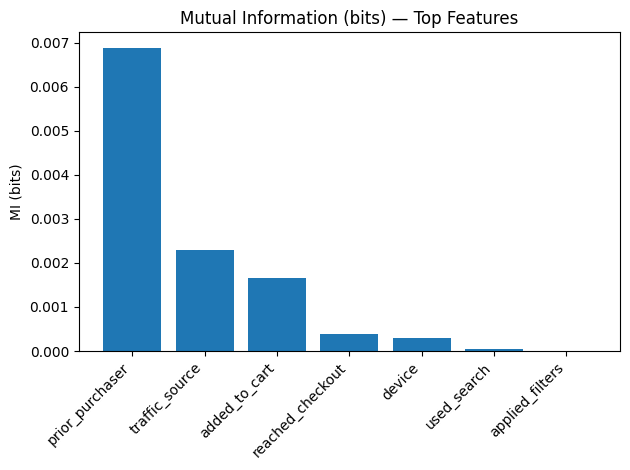

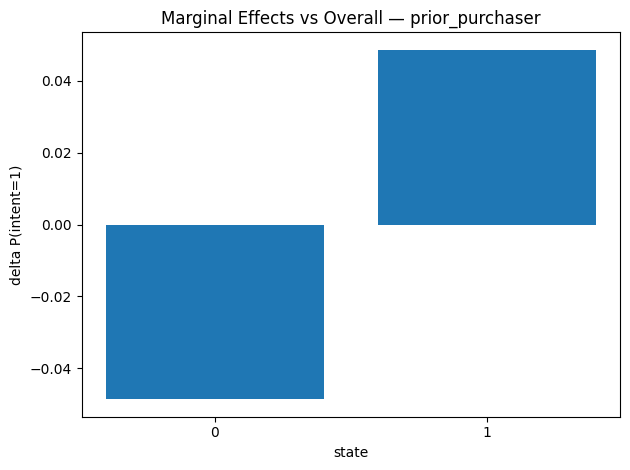

In [7]:
# --- MI Bar Chart ---
top_n = 10
top_mi = mi_df.head(top_n)
plt.figure()
plt.bar(top_mi['feature'], top_mi['MI_bits'])
plt.title('Mutual Information (bits) — Top Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MI (bits)')
plt.tight_layout()
plt.show()

# --- Marginal Effects for one feature ---
example_feature = top_mi.iloc[0]['feature'] if not top_mi.empty else (parent_cols[0] if parent_cols else None)
if example_feature is not None:
    sub = me_df[me_df['feature'] == example_feature]
    plt.figure()
    plt.bar(sub['state'], sub['delta_vs_overall'])
    plt.title(f"Marginal Effects vs Overall — {example_feature}")
    plt.xlabel('state')
    plt.ylabel('delta P(intent=1)')
    plt.tight_layout()
    plt.show()
else:
    print('No features available for marginal effect plot.')


## 6. Basic Validation Metrics and Reliability Curve

{'AUROC': 0.689, 'AUPR': 0.2948, 'Brier': 0.1207}


,bin_left,bin_right,mean_pred,emp_rate
0,0.0,0.1,0.044936,0.084337
1,0.1,0.2,0.136260,0.112676
2,0.2,0.3,0.233333,0.282051
3,0.3,0.4,0.351364,0.285714
4,0.4,0.5,0.433052,0.360000
5,0.5,0.6,0.518317,0.227273
6,0.6,0.7,0.653835,0.400000
7,0.7,0.8,0.723150,0.625000
8,0.9,1.0,0.999350,0.333333


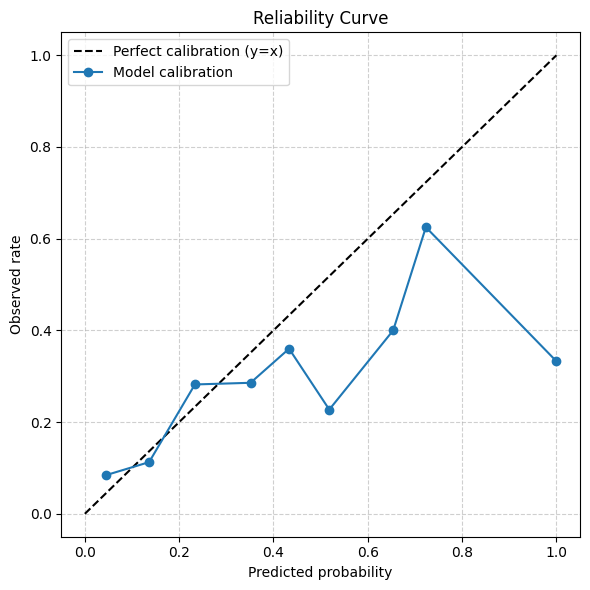

In [10]:
y = val_pred['y'].astype(int).to_numpy()
p = val_pred['p_intent'].astype(float).to_numpy()

# --- Metrics ---
auroc = roc_auc_score(y, p)
aupr = average_precision_score(y, p)
brier = brier_score_loss(y, p)
print({'AUROC': round(auroc, 4), 'AUPR': round(aupr, 4), 'Brier': round(brier, 4)})

# --- Reliability curve (calibration) ---
bins = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(p, bins) - 1
cal = []
for b in range(len(bins) - 1):
    mask = bin_ids == b
    if mask.any():
        cal.append({
            'bin_left': bins[b],
            'bin_right': bins[b + 1],
            'mean_pred': float(p[mask].mean()),
            'emp_rate': float(y[mask].mean())
        })
cal_df = pd.DataFrame(cal)
display(cal_df)

# --- Plot ---
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration (y=x)')
plt.plot(cal_df['mean_pred'], cal_df['emp_rate'], marker='o', color='C0', label='Model calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed rate')
plt.title('Reliability Curve')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 7. Optional: Quick Sensitivity (ΔP) Using CPT
For a categorical feature, compare expected P(intent=1) across its states. This offers a quick sense of directional sensitivity.

In [11]:
def sensitivity_table(feature):
    if feature not in state_expectations:
        raise ValueError(f'Unknown feature: {feature}')
    rows = []
    mapping = state_expectations[feature]
    for s, p1_state in mapping.items():
        rows.append({'state': str(s), 'expected_p_intent_1': float(p1_state)})
    df_feat = pd.DataFrame(rows).sort_values('expected_p_intent_1', ascending=False).reset_index(drop=True)
    return df_feat

if parent_cols:
    feat = parent_cols[0]
    print(f'Example sensitivity for feature: {feat}')
    display(sensitivity_table(feat))
else:
    print('No parent features found.')


Example sensitivity for feature: added_to_cart


,state,expected_p_intent_1
0,1,0.482913
1,0,0.435259
